https://pytorch.org/docs/stable/library.html

```
    node -e 'console.log(require("./workbench/report.json"))'
```

In [1]:
## Initialization
from typing import Callable

from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.PlotModel import PlotModel
from cgtnnlib.Report import Report, eval_report_key
from cgtnnlib.common import DATASETS, LEARNING_RATE, eval_inner
from cgtnnlib.nn.NaiveAugmentedNetwork import NaiveAugmentedNetwork
from cgtnnlib.training import train_model

from cgtnnlib.nn.NetworkLike import NetworkLike
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
from cgtnnlib.nn.DenserAugmentedReLUNetwork import DenserAugmentedReLUNetwork


REPORT = Report(dir="workbench/")
DATASET = DATASETS[2] #3
EPOCHS = 10
# PP = [0.1, 0.5, 0.7, 0.9] # 4pp.json
# PP = [0.8, 1.0] # 2pp.json
PP = [0.1, 0.5, 0.7, 0.8, 0.9, 1.0] # 6pp.json
ITERATIONS = 10


MODEL_CONSTRUCTORS: list[Callable[[int, int, float], NetworkLike]] = [
    AugmentedReLUNetwork,
    DenserAugmentedReLUNetwork,
    # NaiveAugmentedNetwork,
]



MODEL_CONSTRUCTORS

[cgtnnlib.nn.AugmentedReLUNetwork.AugmentedReLUNetwork,
 cgtnnlib.nn.DenserAugmentedReLUNetwork.DenserAugmentedReLUNetwork]

In [2]:
## Training and evaluation
import torch.optim as optim

from cgtnnlib.training import save_model_to_path


for iteration in range(1, ITERATIONS + 1):
    for p in PP:
        for constructor in MODEL_CONSTRUCTORS:
            experiment_params = ExperimentParameters(
                iteration=iteration,
                p=p
            )

            # Training

            model = constructor(
                inputs_count=DATASET.features_count,
                outputs_count=DATASET.classes_count,
                p=experiment_params.p,
            )
            
            running_losses = train_model(
                model=model,
                dataset=DATASET,
                epochs=EPOCHS,
                experiment_params=experiment_params,
                criterion=DATASET.learning_task.criterion,
                optimizer=optim.Adam(
                    model.parameters(),
                    lr=LEARNING_RATE,
                )
            )

            model_path = DATASET.model_path(experiment_params, model)

            save_model_to_path(model, model_path)

            REPORT.record_running_losses(running_losses,
                                         model,
                                         DATASET,
                                         experiment_params)

            # Evaluation

            eval_params = EvaluationParameters(
                dataset=DATASET,
                model_path=model_path,
                experiment_parameters=experiment_params,
                report_key=eval_report_key(
                    model_name=constructor.__name__,
                    dataset_number=DATASET.number,
                    p=p,
                    iteration=iteration,
                )
            )

            eval_inner(
                eval_params=eval_params,
                experiment_params=experiment_params,
                constructor=constructor
            )

REPORT.see()
REPORT.save()

Evaluating model at pth/cgtnn-3X-NaiveAugmentedNetwork-c-P0.9_N10.pth...
Evaluation of regression (head):
   noise_factor        r2        mse
0          0.00  0.025717  14.997963
1          0.04  0.019032  15.100872
2          0.08  0.016805  15.135148
3          0.12  0.021662  15.060379
4          0.16  0.003942  15.333168
Report workbench/report.json
started: '2024-12-05T17:14:21.918777'
loss_NaiveAugmentedNetwork_3_p0.1_N1: list(4360 items)
evaluate_NaiveAugmentedNetwork_3_p0.1_N1: dict(...)
loss_NaiveAugmentedNetwork_3_p0.5_N1: list(4360 items)
evaluate_NaiveAugmentedNetwork_3_p0.5_N1: dict(...)
loss_NaiveAugmentedNetwork_3_p0.7_N1: list(4360 items)
evaluate_NaiveAugmentedNetwork_3_p0.7_N1: dict(...)
loss_NaiveAugmentedNetwork_3_p0.9_N1: list(4360 items)
evaluate_NaiveAugmentedNetwork_3_p0.9_N1: dict(...)
loss_NaiveAugmentedNetwork_3_p0.1_N2: list(4360 items)
evaluate_NaiveAugmentedNetwork_3_p0.1_N2: dict(...)
loss_NaiveAugmentedNetwork_3_p0.5_N2: list(4360 items)
evaluate_NaiveA

/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_4047/3468139574.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_4047/3468139574.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


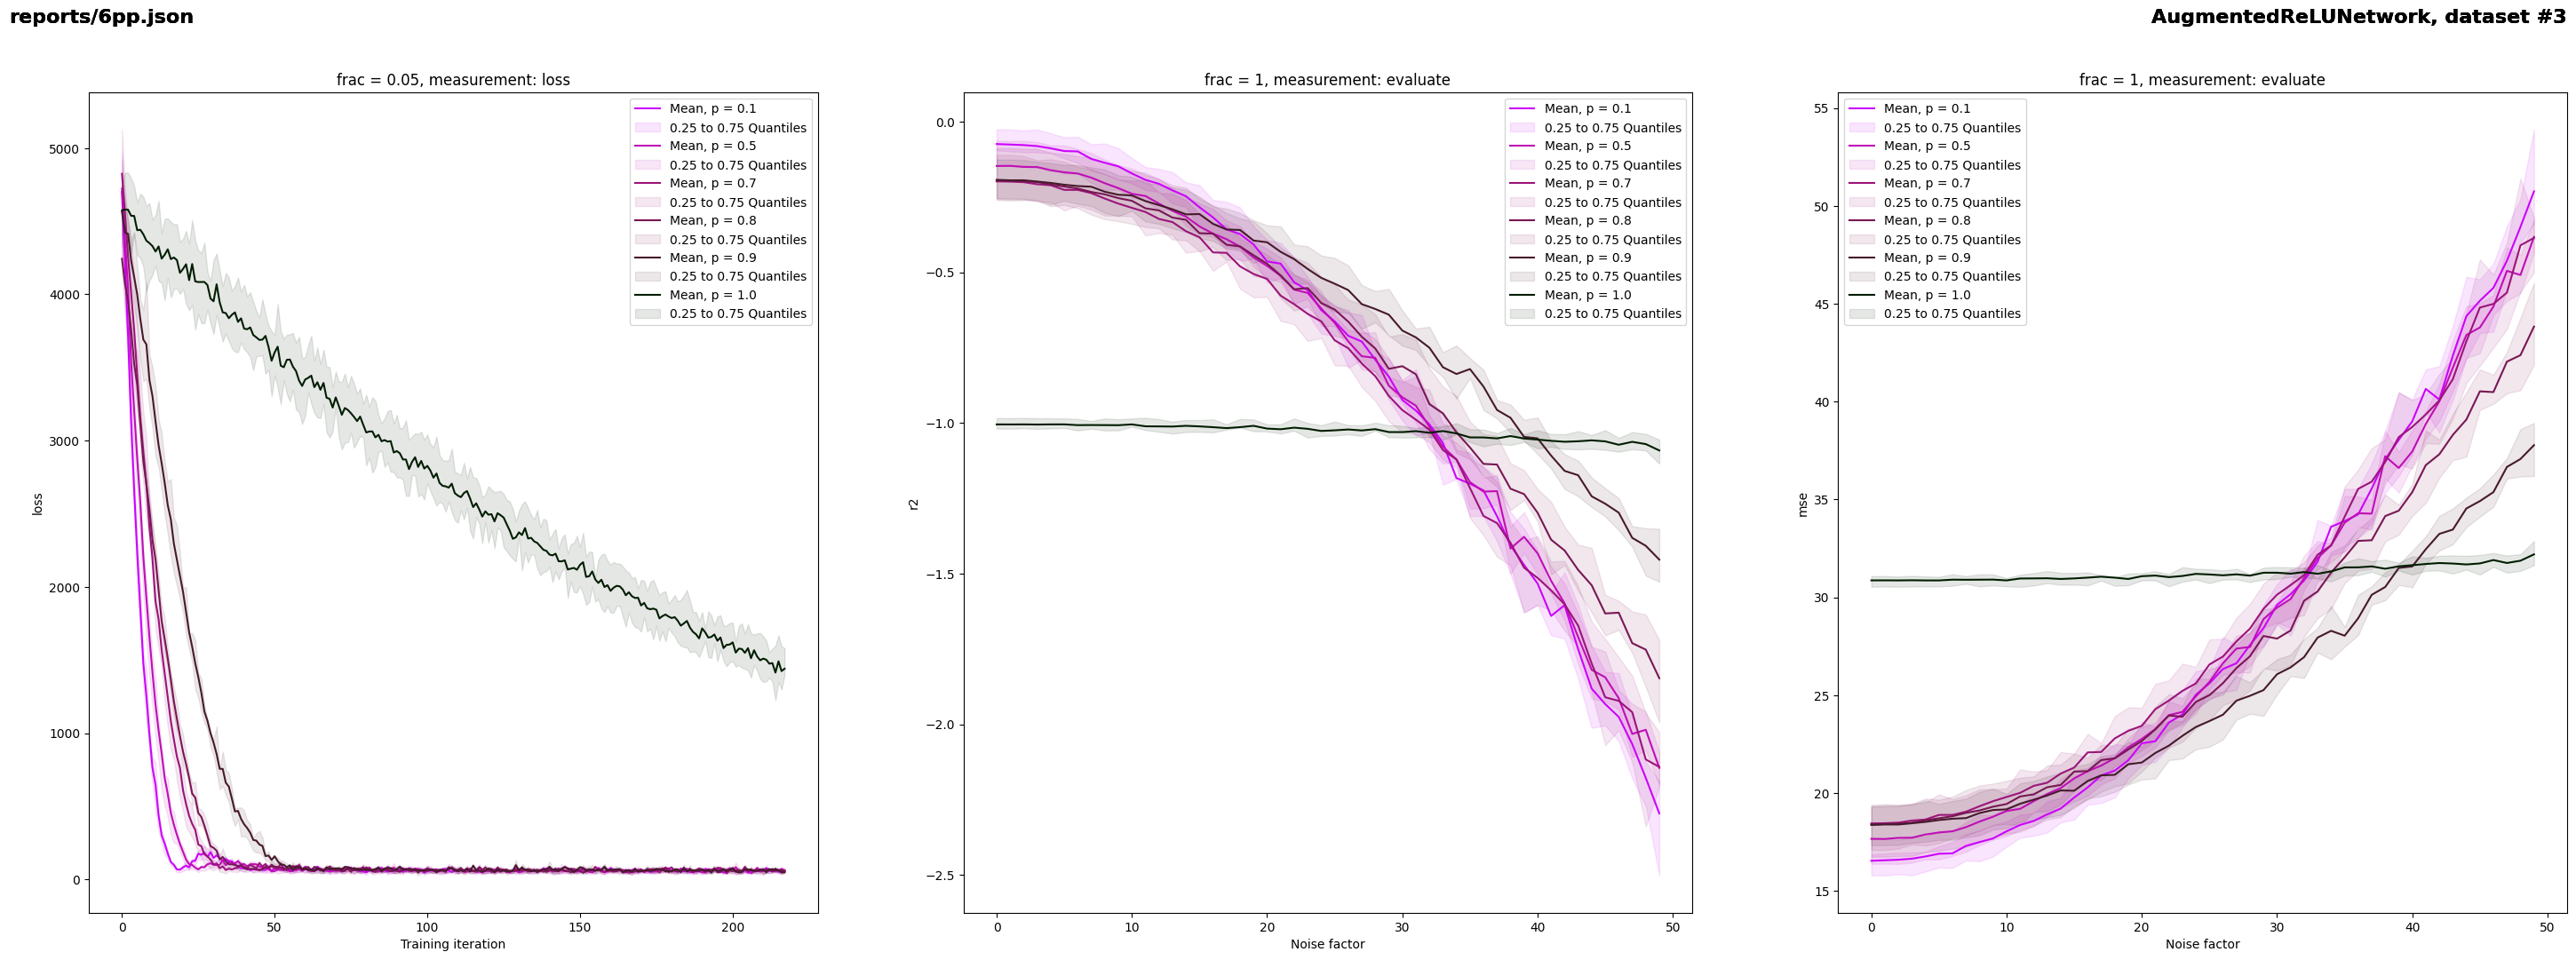

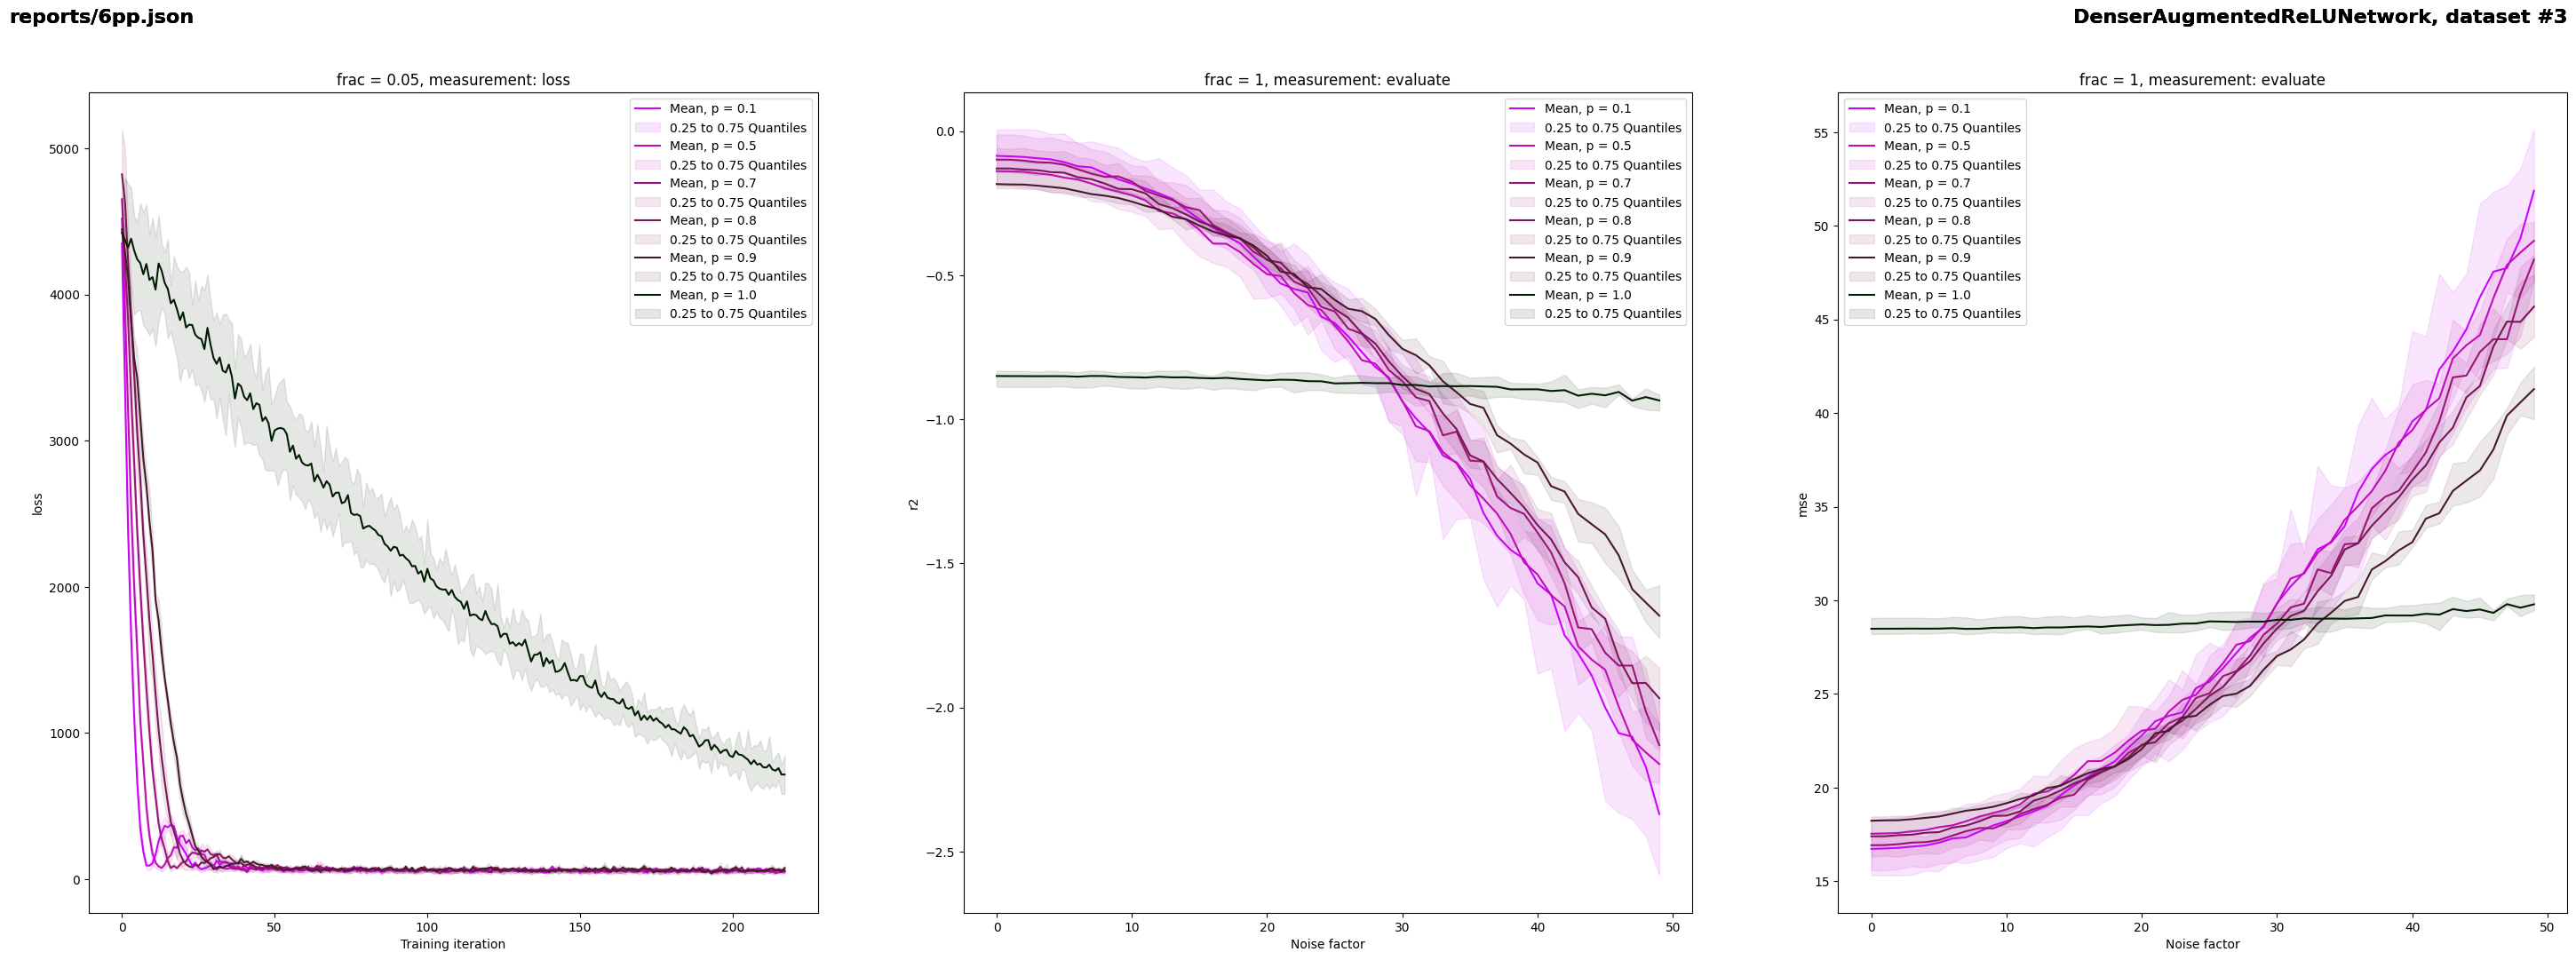

In [7]:
import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt, search_curve_in_report
from cgtnnlib.PlotModel import Measurement, Metric

#report_path = 'reports/4pp-D.json'
report_path = 'reports/6pp.json'

def color_of_p(p: float) -> tuple[int, int, int]:
    return ((1 - p**4) * 0.8, (p ** 1/8) * 0.9, 1 - (p ** 1.8))

def xlabel_for_measaurement(measurement: Measurement) -> str:
    if measurement == 'evaluate':
        return 'Noise factor'
    else:
        return 'Training iteration'

PARAMETERS: list[tuple[Measurement, Metric, float]] = [
    ('loss', 'loss', 0.0125/2*8),
    ('evaluate', 'r2', 1),
    ('evaluate', 'mse', 1),
]
"(measurement, metric, frac)"

for model_name in [x.__name__ for x in MODEL_CONSTRUCTORS]:
    fig, axs = plt.subplots(1, len(PARAMETERS), figsize=(12*3, 4*3))
    for ax, (measurement, metric, frac) in zip(axs, PARAMETERS):
        for p in PP:
            CURVE = search_curve_in_report(
                report_path=report_path,
                model=PlotModel(
                    measurement=measurement,
                    dataset_number=DATASET.number,
                    model_name=model_name,
                    metric=metric,
                    p=p,
                    frac=frac,
                )
            )

            color = color_of_p(p)
            plot_deviant_curves_on_ax_or_plt(
                ax_or_plt=ax,
                models=[{
                    'curve': CURVE,
                    'color': color,
                    'label': f'Mean, p = {p}',
                    'quantiles_color': color,
                    'quantiles_label': '0.25 to 0.75 Quantiles',
                }],
                title=f'frac = {frac}, measurement: {measurement}',
                xlabel=xlabel_for_measaurement(measurement),
                ylabel=metric,
                quantiles_alpha=0.1,
            )

        fig.text(
            x=0.1, y=0.95,
            s=report_path,
            ha='left', va='center', fontsize=16, fontweight='bold'
        )

        fig.text(
            x=0.9, y=0.95,
            s=f'{model_name}, dataset #{DATASET.number}',
            ha='right', va='center', fontsize=16, fontweight='bold'
        )

    fig.show()

In [ ]:

for (measurement, metric, frac) in PARAMETERS:
    for model_name in [x.__name__ for x in MODEL_CONSTRUCTORS]:

